In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import plotly.express as ex

from tqdm.notebook import tqdm
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint

%matplotlib inline

In [81]:
(x,y),(_,_) = keras.datasets.mnist.load_data()

x = x / 255
# x = x / 255

y = pd.get_dummies(y).values
# y = pd.get_dummies(y).values
x = x.reshape(-1,28,28,1)
# x = x.reshape(-1,28,28,1)

In [82]:
labels = y.argmax(axis=1)

In [101]:
X = []
Y = []

for label in np.unique(labels):
    index = np.where(label == labels)[0][:100]
    
    X += list(x[index])
    Y += list(y[index])
    
X = np.array(X)
Y = np.array(Y)

In [107]:
index = np.arange(0,len(X))
np.random.shuffle(index)

In [108]:
X = X[index]
Y = Y[index]

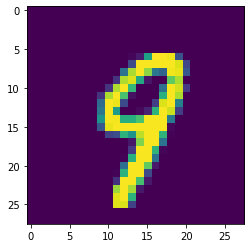

In [109]:
plt.imshow(X[0].reshape(28,28))

In [110]:
inp = Input(shape=(28,28,1))

c = Conv2D(32,3,activation="relu",padding="same",input_shape=(28,28,1))(inp)
c = Conv2D(32,3,activation="relu",padding="same")(c)
c = BatchNormalization()(c)
c = MaxPool2D()(c)
c = Conv2D(32,2,activation="relu")(c)
c = Conv2D(64,3,activation="relu")(c)
c = BatchNormalization()(c)
c = MaxPool2D()(c)
c = Flatten()(c)
c = Dense(512,activation="relu")(c)
c = Dense(128,activation="relu")(c)
l = Dense(64,activation="linear")(c)
c = Dense(10,activation="softmax")(l)

model = keras.Model(inp,c)
encodings = keras.Model(inp,l)

In [111]:
model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy'])

In [112]:
model.fit(X,Y,batch_size=256,epochs=5)

Train on 1000 samples
Epoch 1/5
1000/1000 [==============================] - 1s 993us/sample - loss: 2.6954 - accuracy: 0.2000
Epoch 2/5
1000/1000 [==============================] - 0s 80us/sample - loss: 1.6940 - accuracy: 0.3730
Epoch 3/5
1000/1000 [==============================] - 0s 78us/sample - loss: 1.4052 - accuracy: 0.4810
Epoch 4/5
1000/1000 [==============================] - 0s 81us/sample - loss: 1.2586 - accuracy: 0.5090
Epoch 5/5
1000/1000 [==============================] - 0s 78us/sample - loss: 1.1390 - accuracy: 0.5470


In [113]:
model.evaluate(x,y)

60000/60000 [==============================] - 5s 85us/sample - loss: 2.1983 - accuracy: 0.3629


[2.1982510805765787, 0.36285]

In [114]:
enc = encodings.predict(X,batch_size=256)

In [115]:
ex.scatter(x=enc[:,0],y=enc[:,1],color=Y.argmax(axis=1))

### With 3-D embeddings.

In [116]:
inp = Input(shape=(28,28,1))

c = Conv2D(32,3,activation="relu",padding="same",input_shape=(28,28,1))(inp)
c = Conv2D(32,3,activation="relu",padding="same")(c)
c = BatchNormalization()(c)
c = MaxPool2D()(c)
c = Conv2D(32,2,activation="relu")(c)
c = Conv2D(64,3,activation="relu")(c)
c = BatchNormalization()(c)
c = MaxPool2D()(c)
c = Flatten()(c)
c = Dense(512,activation="relu")(c)
c = Dense(128,activation="relu")(c)
l = Dense(64,activation="linear")(c)
c = Dense(10,activation="softmax")(l)

model = keras.Model(inp,c)
encodings = keras.Model(inp,l)

In [117]:
model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy'])

In [118]:
model.fit(X,Y,batch_size=32,epochs=5)

Train on 1000 samples
Epoch 1/5
1000/1000 [==============================] - 1s 985us/sample - loss: 1.4585 - accuracy: 0.5350
Epoch 2/5
1000/1000 [==============================] - 0s 198us/sample - loss: 0.5125 - accuracy: 0.8110
Epoch 3/5
1000/1000 [==============================] - 0s 196us/sample - loss: 0.2353 - accuracy: 0.9380
Epoch 4/5
1000/1000 [==============================] - 0s 195us/sample - loss: 0.0854 - accuracy: 0.9820
Epoch 5/5
1000/1000 [==============================] - 0s 199us/sample - loss: 0.0457 - accuracy: 0.9920


In [119]:
enc = encodings.predict(X,batch_size=256)

In [120]:
ex.scatter_3d(x=enc[:,0],y=enc[:,1],z=enc[:,2],color=Y.argmax(axis=1))

### Generating Pairs

In [189]:
def base_network(d):
    _input = Input(shape=(28,28,1))

    a_conv0 = Conv2D(32,3,activation="relu",padding="same")(_input)
    a_conv1 = Conv2D(32,3,activation="relu",padding="same")(a_conv0)
    a_conv2 = Conv2D(32,3,activation="relu",padding="same")(a_conv1)
    a_conc = concatenate([a_conv0,a_conv2,a_conv2])
    a_pool = MaxPool2D()(a_conc)

    b_conv0 = Conv2D(64,3,activation="relu",padding="same")(a_pool)
    b_conv1 = Conv2D(64,3,activation="relu",padding="same")(b_conv0)
    b_conv2 = Conv2D(64,3,activation="relu",padding="same")(b_conv1)
    b_conc = concatenate([b_conv0,b_conv2,b_conv2])
    b_pool = MaxPool2D()(b_conc)

    dense = Flatten()(b_pool)
    dense = Dense(512,activation="linear")(dense)
    dense = Dense(d,activation="tanh")(dense)
    dense = tf.multiply(dense,128)
    model = keras.Model(_input,dense,name="Net")

    return model

In [210]:
net = base_network(64)

In [211]:
net.summary()

Model: "Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 28, 28, 32)   320         input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 28, 28, 32)   9248        conv2d_38[0][0]                  
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 28, 28, 32)   9248        conv2d_39[0][0]                  
________________________________________________________________________________________________

In [212]:
class Pairs(tf.Module):
    def __init__(self,net,x,y):
        self.net = net
        self.x = tf.constant(x.reshape(-1,*x[0].shape[:2],1).copy(),tf.float32)
        self.y = tf.constant(y.copy(),tf.uint8)       
        self.y_ = tf.argmax(self.y,axis=1)
        self.range_tensor = tf.range(0,len(x),dtype=tf.int32)
        self.dummy = tf.constant([[0]],dtype=tf.float32)
        
    def __repr__(self,):
        return """Pairs Generator"""
        
    @tf.function
    def l2(self,x,y):
        return tf.square(tf.subtract(x,y))
    
    @tf.function
    def get_pair(self,i):
        
        x = tf.slice(self.x,[i,0,0,0],[1,-1,-1,-1])
        y = tf.slice(self.y_,[i],[1])
        e = tf.slice(self.epoch_emb,[i,0],[1,-1])

        p_index = tf.equal(y,self.y_)
        n_index = tf.not_equal(y,self.y_)

        p_dist = self.epoch_emb[p_index]
        n_dist = self.epoch_emb[n_index]

        p = tf.argmax(tf.reduce_sum(tf.square(tf.subtract(e,p_dist)),axis=1))
        n = tf.argmin(tf.reduce_sum(tf.square(tf.subtract(e,n_dist)),axis=1))
        
        p = tf.expand_dims(self.x[p_index][p],0)
        n = tf.expand_dims(self.x[n_index][n],0)

        return (x,p,n),self.dummy
    
    def flow(self,epochs):
        for epoch in range(epochs):
            self.epoch_emb = tf.constant(self.net.predict(self.x,batch_size=512),tf.float32)
            for i in self.range_tensor:
                yield self.get_pair(i)
                

In [213]:
pairs = Pairs(net,X,Y)
flow = pairs.flow(1)

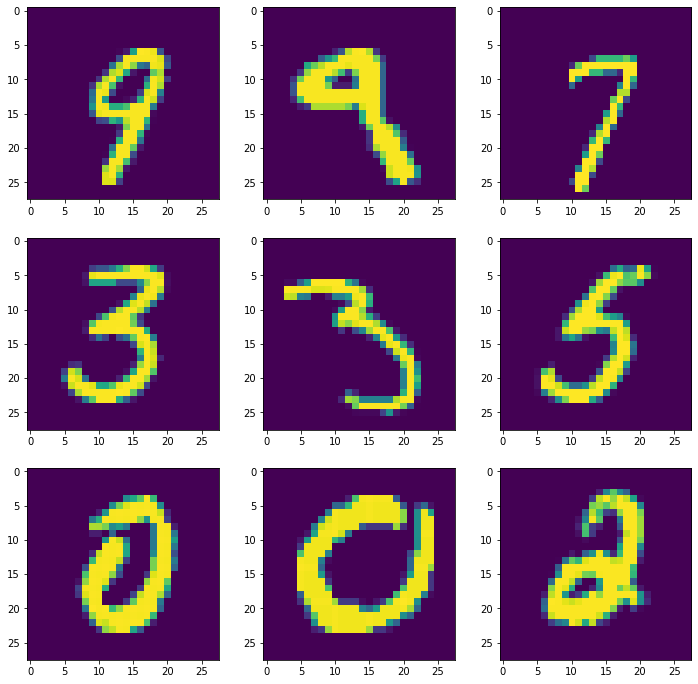

In [214]:
fig,axes = plt.subplots(3,3,figsize=(12,12))

for ax in axes:
    (a,p,n),_ = next(flow)
    
    a = a.numpy()
    p = p.numpy()
    n = n.numpy()
    
    ax[0].imshow(a.reshape(28,28))
    ax[1].imshow(p.reshape(28,28))
    ax[2].imshow(n.reshape(28,28))

### Triplet Net

In [215]:
a_inp = Input(shape=(28,28,1),name="a")
p_inp = Input(shape=(28,28,1),name="p")
n_inp = Input(shape=(28,28,1),name="n")

a_enc = net(a_inp)
p_enc = net(p_inp)
n_enc = net(n_inp)

out = concatenate([a_enc,p_enc,n_enc])

train = keras.Model([a_inp,p_inp,n_inp],out)

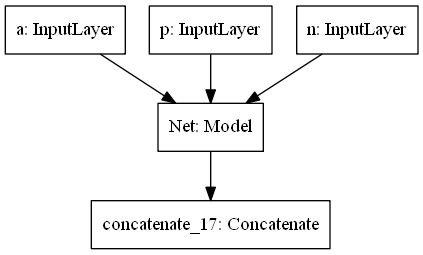

In [216]:
keras.utils.plot_model(train)

### Triplet Loss


![triplt.png](triplet.png)

In [224]:
class Triplet(tf.Module):
    """
    Triplet Loss
    """
    def __init__(self,margin=1.):
        self.margin = margin
        
    @tf.function
    def l2(self,x,y):
        return tf.reduce_sum(tf.square(tf.subtract(x,y)))
    
    @tf.function
    def __call__(self,y_true,y_pred,*args,**kwargs):
        a,p,n = tf.unstack(tf.reshape(y_pred,(3,-1,64)))
        
        Dp = self.l2(a,p)
        Dn = self.l2(a,n)
        
        return tf.nn.relu(Dp - Dn + self.margin)

In [225]:
chk = ModelCheckpoint(filepath="triplet/chk_0",save_weights_only=True)

In [226]:
triplet = Triplet(5)

In [227]:
adam = keras.optimizers.Adamax(0.00001)

In [228]:
train.compile(optimizer=adam,loss=triplet)

In [229]:
pairs = Pairs(net,X,Y)
flow = pairs.flow(20)

In [230]:
train.fit_generator(flow,steps_per_epoch=X.shape[0],epochs=20,callbacks=[chk])

  ...
    to  
  ['...']
Train for 1000 steps
Epoch 1/20
1000/1000 [==============================] - 14s 14ms/step - loss: 809.2212
Epoch 2/20
1000/1000 [==============================] - 16s 16ms/step - loss: 103.2797
Epoch 3/20
1000/1000 [==============================] - 13s 13ms/step - loss: 36.2280
Epoch 4/20
1000/1000 [==============================] - 13s 13ms/step - loss: 15.9714
Epoch 5/20
1000/1000 [==============================] - 13s 13ms/step - loss: 7.1898
Epoch 6/20
1000/1000 [==============================] - 13s 13ms/step - loss: 2.6706
Epoch 7/20
1000/1000 [==============================] - 15s 15ms/step - loss: 0.7976
Epoch 8/20
1000/1000 [==============================] - 16s 16ms/step - loss: 0.1104
Epoch 9/20
1000/1000 [==============================] - 17s 17ms/step - loss: 0.1585
Epoch 10/20
1000/1000 [==============================] - 17s 17ms/step - loss: 0.0521
Epoch 11/20
1000/1000 [==============================] - 17s 17ms/step - loss: 0.0193
Epoch 12/20

In [232]:
cords = net.predict(X,batch_size=256)

In [237]:
from sklearn.manifold import TSNE
from seaborn import scatterplot

In [238]:
tsne = TSNE(3)

In [239]:
xyz = tsne.fit_transform(cords)

In [240]:
ex.scatter_3d(x=xyz[:,0],y=xyz[:,1],z=xyz[:,2],color=Y.argmax(axis=1))

In [241]:
tsne = TSNE(2)

In [242]:
xy = tsne.fit_transform(cords)

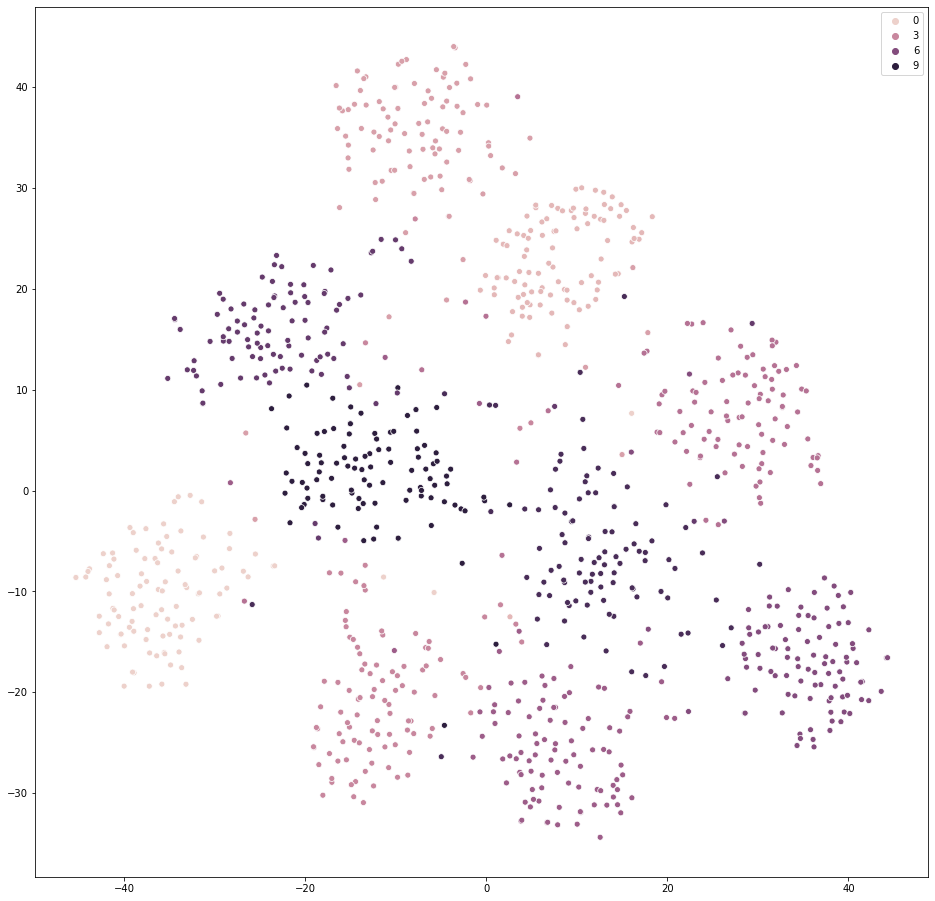

In [243]:
plt.figure(figsize=(16,16))
scatterplot(xy[:,0],xy[:,1],hue=Y.argmax(axis=1).astype(str))